In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import statsmodels.api as sm

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
df = pd.read_csv('data/churn_train.csv',parse_dates = ['last_trip_date','signup_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
avg_dist                  40000 non-null float64
avg_rating_by_driver      39838 non-null float64
avg_rating_of_driver      33472 non-null float64
avg_surge                 40000 non-null float64
city                      40000 non-null object
last_trip_date            40000 non-null datetime64[ns]
phone                     39681 non-null object
signup_date               40000 non-null datetime64[ns]
surge_pct                 40000 non-null float64
trips_in_first_30_days    40000 non-null int64
luxury_car_user           40000 non-null bool
weekday_pct               40000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.4+ MB


In [5]:
for i in df.columns:
    print(i,len(df[i].unique()))

avg_dist 2764
avg_rating_by_driver 28
avg_rating_of_driver 38
avg_surge 111
city 3
last_trip_date 182
phone 3
signup_date 31
surge_pct 357
trips_in_first_30_days 57
luxury_car_user 2
weekday_pct 641


5.0
4.777433606104486


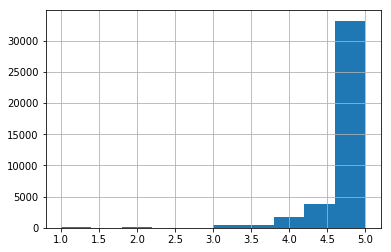

In [6]:
col = 'avg_rating_by_driver'
print(df[col].median())
print(df[col].mean())
df[col].hist()


In [7]:
#df = pd.read_csv('data/churn_train.csv',parse_dates = ['last_trip_date','signup_date'])
from data_clean import Cleaner

today = pd.datetime(2014,7,1)
churn_thresh = pd.Timedelta(30, 'D')
churn =(today-df['last_trip_date'] >churn_thresh).astype('int64').values

clnr = Cleaner()
clnr.stage_cleaning(df)
clean_data = clnr.clean(df)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 12 columns):
Android           40000 non-null uint8
rider_rtg         40000 non-null float64
driver_rtg        40000 non-null float64
avg_dist          40000 non-null float64
avg_surge         40000 non-null float64
surge_pct         40000 non-null float64
first_30          40000 non-null int64
black             40000 non-null int64
weekday_pct       40000 non-null float64
weekend_signup    40000 non-null bool
Astapor           40000 non-null uint8
Winterfell        40000 non-null uint8
dtypes: bool(1), float64(6), int64(2), uint8(3)
memory usage: 2.6 MB


In [8]:
X_train, X_test, y_train, y_test = train_test_split(clean_data, churn,
                                                    test_size = 0.2,random_state = 142)

In [9]:
gb = GradientBoostingClassifier(learning_rate=0.005,max_depth=10,
                                n_estimators = 1000,min_samples_leaf=50, max_features = 5)
#this is on a split of the training data
gb.fit(X_train,y_train)
print(gb.score(X_test,y_test))
y_test_hat = gb.predict(X_test)

0.791875


In [10]:
df_test = pd.read_csv('data/churn_train.csv',parse_dates = ['last_trip_date','signup_date'])

churn_test =(today-df_test['last_trip_date'] >churn_thresh).astype('int64').values
clean_data_test = clnr.clean(df_test)

gb.fit(clean_data,churn)
print(gb.score(clean_data_test,churn_test))
#0.826225

0.827


In [13]:
print(confusion_matrix(y_test,y_test_hat))
print(np.sum(y_test))
print(np.sum(y_test_hat))
print(gb.score(X_test,y_test))
y_test_hat = gb.predict(X_test)

[[4349. 1024.]
 [ 641. 1986.]]
4990
5373
0.830375


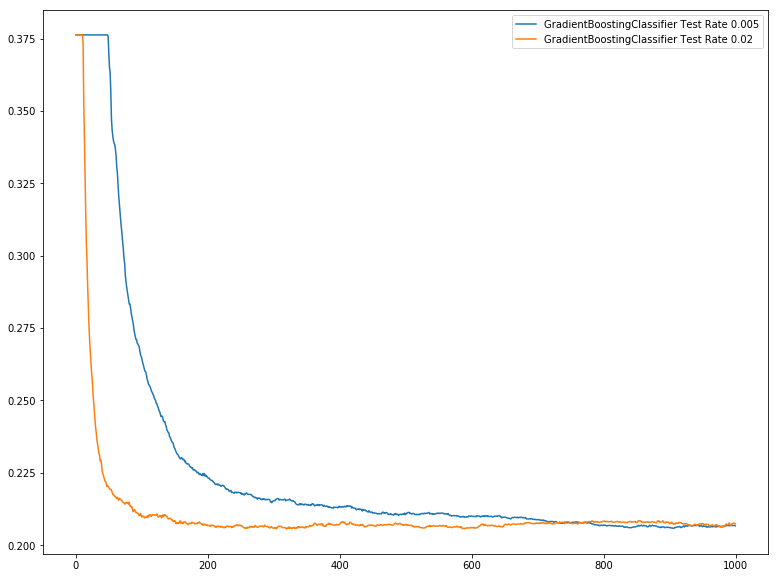

In [16]:
#gb.score(scaler.transform(X_test),y_test)
plt.figure(figsize = (13,10))
gb = GradientBoostingClassifier(learning_rate=0.005,max_depth=8,
                                n_estimators = 1000,min_samples_leaf=10, max_features = 3)
gb2 = GradientBoostingClassifier(learning_rate=0.02,max_depth=10,
                                n_estimators = 1000,min_samples_leaf=50, max_features = 3)
stage_score_plot(gb, X_train, y_train, X_test, y_test)
stage_score_plot(gb2, X_train, y_train, X_test, y_test)


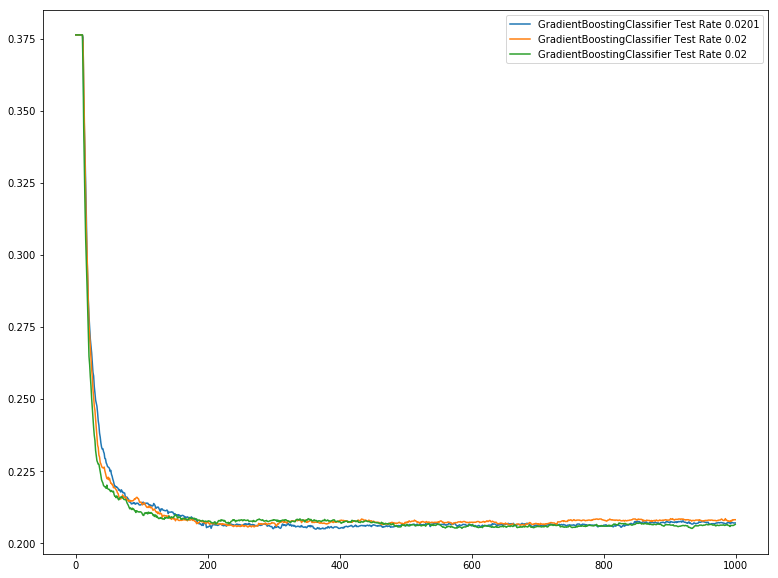

In [209]:
plt.figure(figsize = (13,10))
gb3 = GradientBoostingClassifier(learning_rate=0.0201,max_depth=10,
                                n_estimators = 1000,min_samples_leaf=100, max_features = 3)
gb4 = GradientBoostingClassifier(learning_rate=0.02,max_depth=10,
                                n_estimators = 1000,min_samples_leaf=50, max_features = 3)
gb5 = GradientBoostingClassifier(learning_rate=0.02,max_depth=10,
                                n_estimators = 1000,min_samples_leaf=50, max_features = 5)
stage_score_plot(gb3, X_train, y_train, X_test, y_test)
stage_score_plot(gb4, X_train, y_train, X_test, y_test)
stage_score_plot(gb5, X_train, y_train, X_test, y_test)

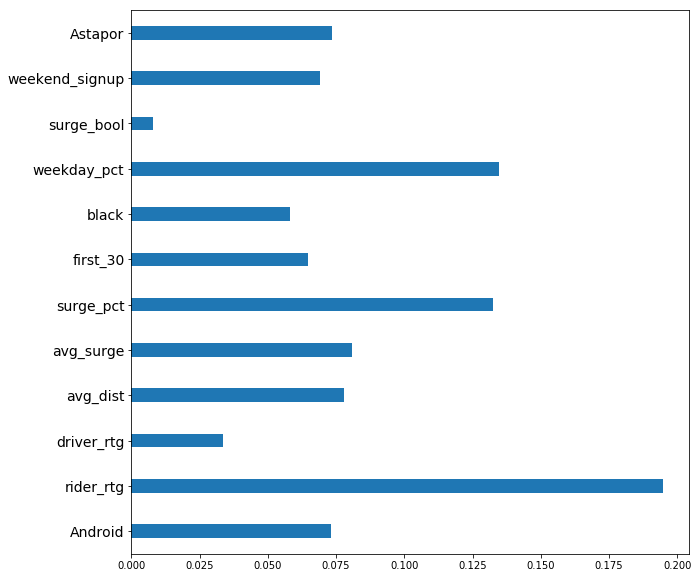

In [230]:
top_cols = np.argsort(gb.feature_importances_)
importances =gb.feature_importances_
fig = plt.figure(figsize=(10, 10))
x_ind = np.arange(importances.shape[0])
plt.barh(x_ind, importances, height=.3, align='center')
plt.ylim(x_ind.min() -0.5, x_ind.max() + 0.5)
plt.yticks(x_ind, X_test.columns, fontsize=14)
plt.show()

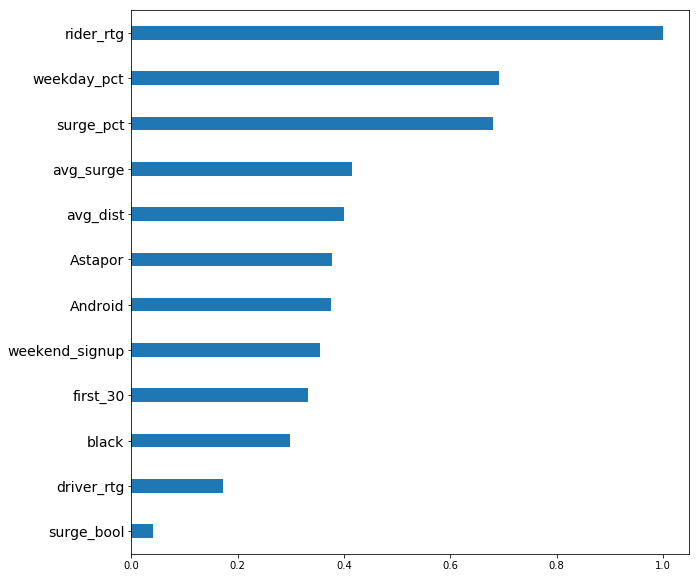

In [236]:
top_cols = np.argsort(gb.feature_importances_)
importances =gb.feature_importances_[top_cols]
fig = plt.figure(figsize=(10, 10))
x_ind = np.arange(importances.shape[0])
plt.barh(x_ind, importances/importances[-1:], height=.3, align='center')
plt.ylim(x_ind.min() -0.5, x_ind.max() + 0.5)
plt.yticks(x_ind, X_test.columns[top_cols], fontsize=14)
plt.show()

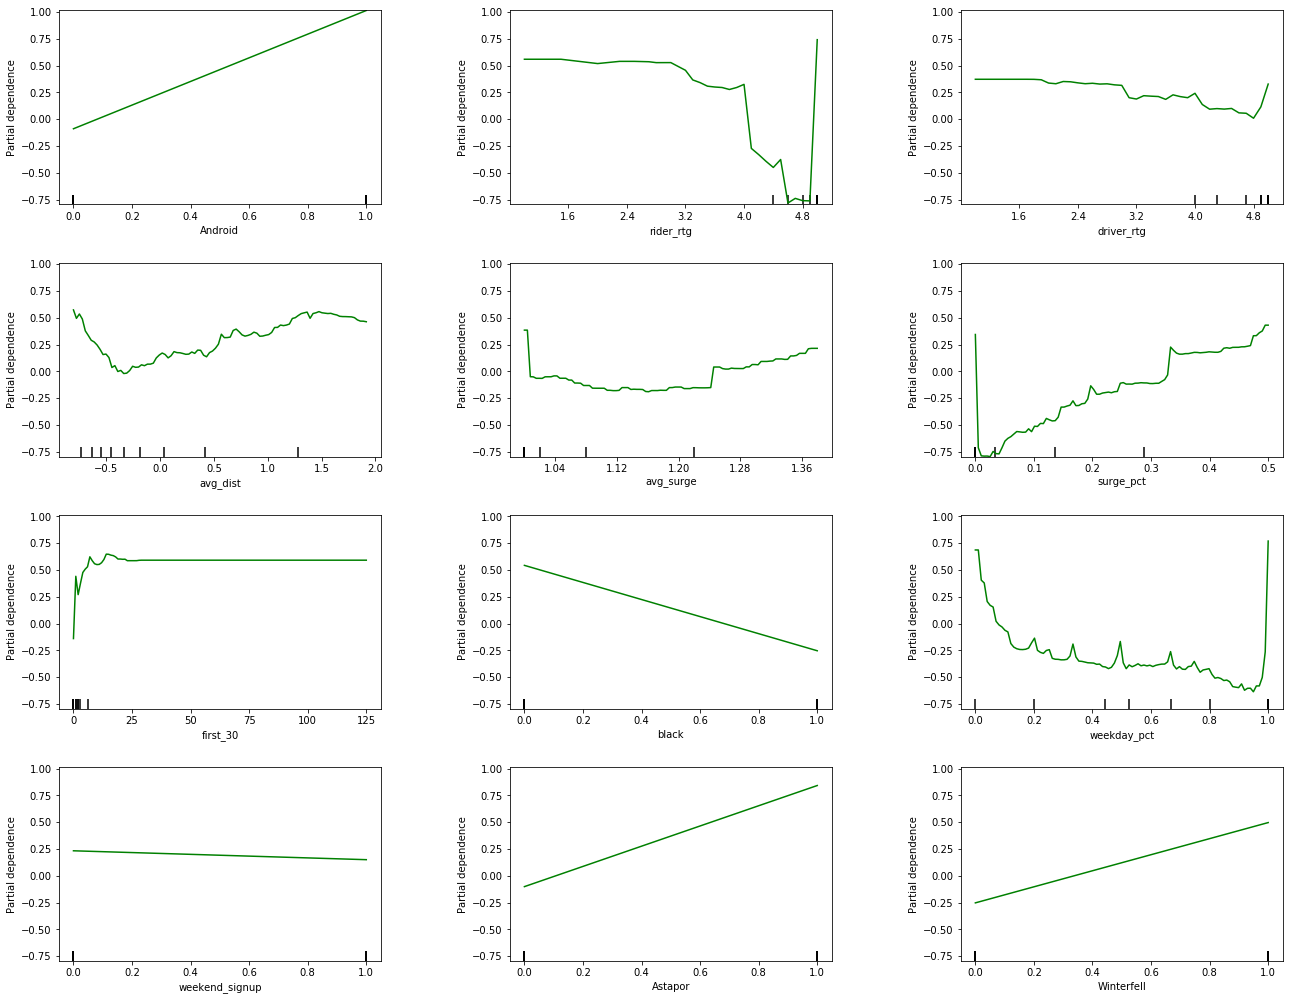

In [233]:
fig, axs = plot_partial_dependence(gb, clean_data, np.arange(clean_data.shape[1]),
                                    n_jobs=3, grid_resolution=100,feature_names = clean_data.columns)
fig.set_size_inches((20,24))

In [128]:
def get_equal_samples(X,y_hat,y,n = 1000):
    #X is DF, y_hat and y are np arrays
    y_hat_pd = pd.Series(y_hat)
    y_pd = pd.Series(y_hat)
    right_ind = y_pd[(y_hat==y)].index
    wrong_ind = y_pd[(y_hat!=y)].index
    
    right_sample = np.random.choice(right_ind, size = n,replace = False)
    wrong_sample = np.random.choice(wrong_ind, size = n,replace = False)
    return X.iloc[right_sample,:],y_pd[right_sample],X.iloc[wrong_sample,:],y_pd[wrong_sample]

In [157]:
x_right,y_right,x_wrong,y_wrong = get_equal_samples(X_test,y_test_hat,y_test)
x_right.shape

(1000, 15)

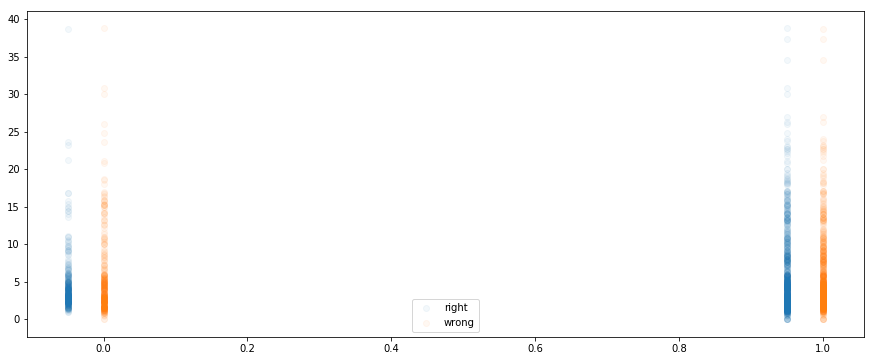

In [158]:
fig, ax = plt.subplots(1,1,figsize = (15,6))
col = 'avg_dist'
ax.scatter(y_right-0.05,x_right[col],alpha = 0.05,label = 'right')
ax.scatter(y_wrong,x_right[col],alpha = 0.05,label = 'wrong')
ax.legend()
plt.show()

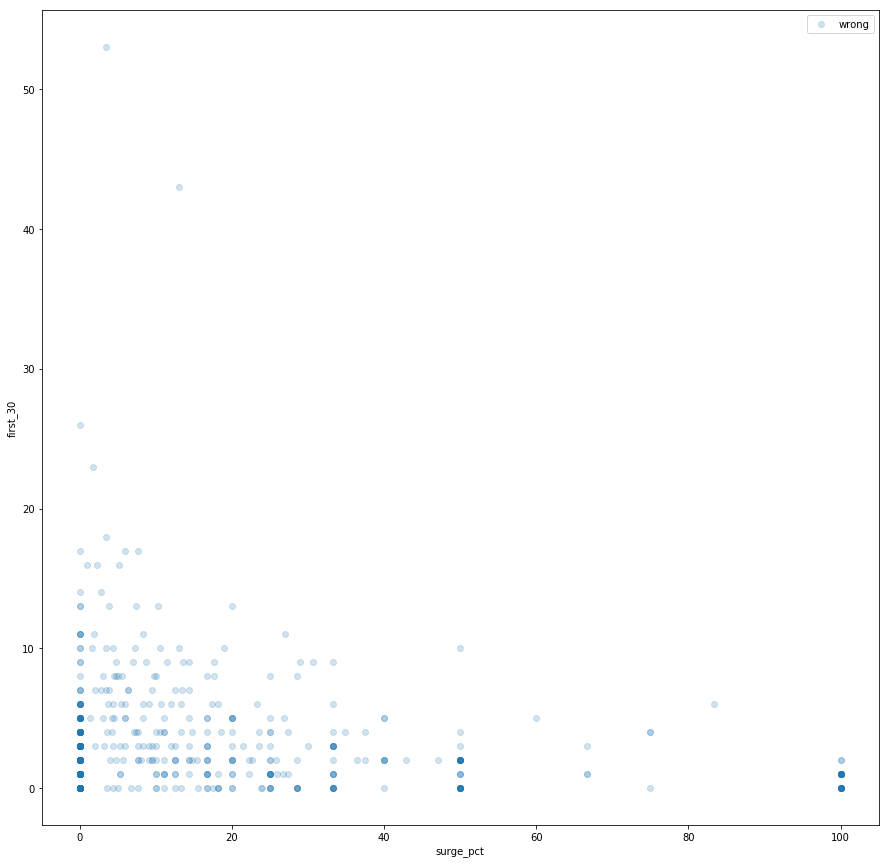

In [147]:
fig, ax = plt.subplots(1,1,figsize = (15,15))
col = 'surge_pct'
col2 = 'first_30'
#ax.scatter(x_right[col],x_right[col2],alpha = 0.08,label = 'right')
ax.scatter(x_right[col],x_right[col2],alpha = 0.2,label = 'wrong')
ax.set_xlabel(col)
ax.set_ylabel(col2)
ax.legend()
plt.show()

In [153]:
col = 'rider_rtg'
print(x_right[col].mean())
print(x_wrong[col].mean())
print(X_test[col].mean())

4.775900000000002
4.753400000000003
4.772612500000034


In [170]:
gb.score(x_norm,y_train)

0.6805625

In [39]:
from sklearn.ensemble.partial_dependence import partial_dependence
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [15]:
def stage_score_plot(estimator, X_train, y_train, X_test, y_test):
    '''
    Parameters: estimator: GradientBoostingRegressor or AdaBoostRegressor
                X_train: 2d numpy array
                y_train: 1d numpy array
                X_test: 2d numpy array
                y_test: 1d numpy array

    Returns: A plot of the number of iterations vs the MSE for the model for
    both the training set and test set.
    '''
    mse_train = np.zeros(estimator.n_estimators)
    mse_test = np.zeros(estimator.n_estimators)
    estimator.fit(X_train,y_train)
    for ind, (yh_test,yh_train) in enumerate(zip(estimator.staged_predict(X_test),
                                                 estimator.staged_predict(X_train))):
        mse_test[ind]=np.sum(yh_test!=y_test)/len(y_test)
    
    plt.plot(np.r_[0:estimator.n_estimators],mse_test,
             label ='{} Test Rate {}'.format(estimator.__class__.__name__, estimator.learning_rate))
    plt.legend()

In [83]:
gb_grid = {'learning_rate':[0.01,0.1],
          'max_depth':[None],
          'min_samples_leaf':[1],
          'n_estimators':[500],
          'max_features':[None]}
gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gb_grid,
                             n_jobs=1,
                             verbose=True,
                             scoring='neg_log_loss')
gb_gridsearch.fit(X_train, y_train)
print( "best parameters:", gb_gridsearch.best_params_ )
best_gb_model = gb_gridsearch.best_estimator_

best_gb_model.fit(X_train.values,y_train)
print(best_gb_model.score(X_test,y_test))

/Users/shane/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 2 candidates, totalling 6 fits


KeyboardInterrupt: 

In [249]:
clean_data.shape

AttributeError: 'function' object has no attribute 'shape'

In [ ]:
pipeline = Pipeline([('scaler', StandardScaler()),
                        ('svc', SVC(kernel='rbf'))])

rbf_grid = {'svc__C':[1,10,100],
        'svc__gamma':['auto','scale'],
           'svc__class_weight':['balanced',None]}

rbf_gridsearch = GridSearchCV(pipeline,
                             rbf_grid,
                            n_jobs=-1,
                             verbose=True,
                             cv=2)
rbf_gridsearch.fit(clean_data, churn.reshape(-1,1))
print( "best parameters:", rbf_gridsearch.best_params_ )
best_rbf_model = rbf_gridsearch.best_estimator_
print('Best RBF score:{}'.format(best_rbf_model.score(clean_data_test,churn_test)))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [12]:
def confusion_matrix(y, y_pred):
    confusion = np.zeros((2,2))
    for i in range(2):
        for j in range(2):
            confusion[j,i] = np.sum((y_pred !=j)[y!=i])
    return confusion

In [ ]:
top_cols = np.argsort(best_gb_model.feature_importances_)
importances =best_gb_model.feature_importances_[top_cols]
fig = plt.figure(figsize=(10, 10))
x_ind = np.arange(importances.shape[0])
plt.barh(x_ind, importances/importances[-1:], height=.3, align='center')
plt.ylim(x_ind.min() -0.5, x_ind.max() + 0.5)
plt.yticks(x_ind, top_names, fontsize=14)
plt.show()

In [ ]:
np.